In [1]:
import os 
import certifi
from pymongo.mongo_client import MongoClient
from wordcloud import WordCloud

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dotenv import load_dotenv
load_dotenv()

d:\miniconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

In [2]:
ACC_DB = os.getenv("DB_ACC")
client = MongoClient(ACC_DB, ssl_ca_certs=certifi.where())
db = client.get_database("movies_db")
collection = db.get_collection("movies_list")

In [3]:
def collect_reviews():
    query = collection.aggregate([{ "$sample": { "size": 1000 } }])
    reviews_list = []

    for q in query:
        reviews = q["reviews"]
        for r in reviews:
            reviews_list.append(r["review"])
            
    return reviews_list


In [4]:
def wc(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') 
    plt.show()

In [5]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def pre_process(text, custom_stopwords=None):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    if custom_stopwords:
        stop_words.update(custom_stopwords)

    words = [word for word in words if word.lower() not in stop_words]

    preprocessed_text = ' '.join(words)

    return preprocessed_text

In [6]:
reviews = collect_reviews()

In [7]:
rotj = collection.find_one({"original_title": "The Killer"})
rotj_reviews = [i["review"] for i in rotj["reviews"]]
roth_reviews_words = [word for review in rotj_reviews for word in review.split(" ")]
rotj_reviews_processed = " ".join(rotj_reviews)
rotj_reviews_processed = pre_process(rotj_reviews_processed, ["movie", "s", "t", "film", "one", "amp", "S"])

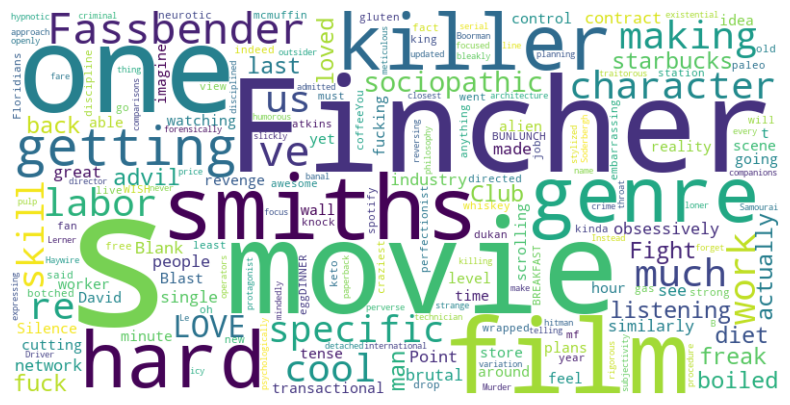

In [8]:
wc(" ".join(rotj_reviews))

783.5083110843166 350.0


d:\miniconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


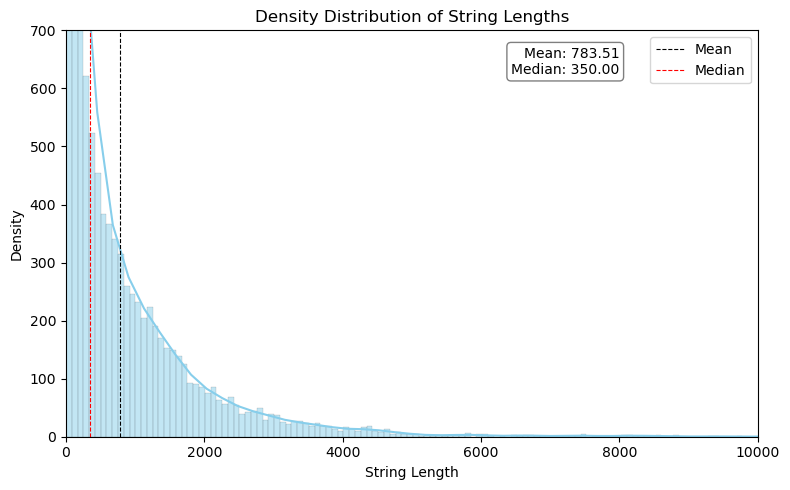

In [9]:
lengths = [len(s) for s in reviews]
mean = np.mean(lengths)
median = np.median(lengths)

print(mean, median)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lengths, kde=True, color='skyblue', ax=ax)
ax.axvline(mean, color='black', linestyle='dashed', linewidth=0.8, label='Mean')
ax.axvline(median, color='red', linestyle='dashed', linewidth=0.8, label='Median')
ax.set_xlim(0, 10000)
ax.set_ylim(0, 700)
ax.set_xlabel('String Length')
ax.set_ylabel('Density')
ax.set_title('Density Distribution of String Lengths')
ax.legend()  

text_str = f'Mean: {mean:.2f}\nMedian: {median:.2f}'
ax.text(0.8, 0.96, text_str, transform=ax.transAxes, va='top', ha='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

computationally detecting jokes and text is challanging and potentially dangerous. Hence, in order to spot humor (whatever it is) we can instead read through the reviews that possess the most common words in both the first 25% of the data compared against the 50-75% portion of it.

In [10]:
rotj_reviews

[' I said I LOVE THE SMITHS',
 ' least sociopathic the smiths fan',
 ' drop the spotify wrapped king',
 ' that is indeed what listening to the smiths will do to a mf',
 ' The Killer is a movie about how awesome and embarrassing it must be for a 60 year old man to live with the fact that he directed Fight Club  not at all a knock against Fight Club  I kinda loved it ',
 ' This man freak out here with the craziest keto gluten free paleo dukan atkins diet BREAKFAST  mcmuffin with NO BUNLUNCH  hard boiled gas station eggDINNER  advil  whiskey  and starbucks coffeeYou WISH you had his discipline  ',
 ' Floridians are actually that strong',
 ' Hard to view this as anything but a neurotic perfectionist who botched his last job  went  oh fuck  this is new  and had to go back to the forensically focused  obsessively stylized  and psychologically perverse outsider serial killer genre fare he made a name for himself on  I can see where people are getting the detached  existential loner criminal s

In [11]:
from collections import Counter

def find_most_common_words(word_list, custom_stopwords=None, n=20):
    if custom_stopwords is None:
        custom_stopwords = [""]
    
    words = word_tokenize(" ".join(word_list))
    stop_words = set(stopwords.words('english'))

    stop_words.update(custom_stopwords)
    
    words = [word.lower() for word in words if word.lower() not in stop_words]

    word_counts = Counter(words)

    most_common_words = word_counts.most_common(n)

    return most_common_words

short_reviews = [review for review in rotj_reviews if len(review) < 360]
long_reviews = [review for review in rotj_reviews if len(review) > 360]
top_long_reviews_words = find_most_common_words(long_reviews, ["like", "one"], 20)
top_short_reviews_words = find_most_common_words(short_reviews, ["like", "one"], 20)

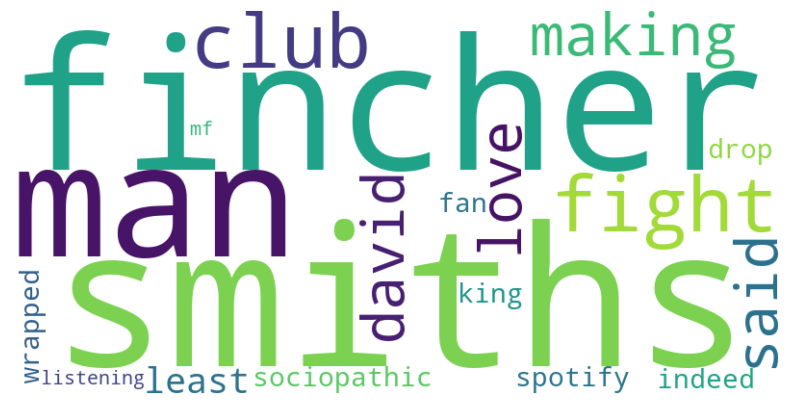

In [12]:
wc(" ".join([word[0] for word in top_short_reviews_words]))

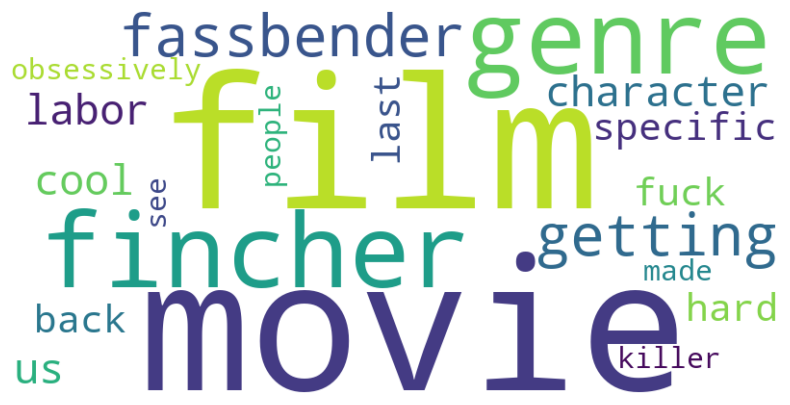

In [13]:
wc(" ".join([word[0] for word in top_long_reviews_words]))

In [14]:
short_reviews

[' I said I LOVE THE SMITHS',
 ' least sociopathic the smiths fan',
 ' drop the spotify wrapped king',
 ' that is indeed what listening to the smiths will do to a mf',
 ' The Killer is a movie about how awesome and embarrassing it must be for a 60 year old man to live with the fact that he directed Fight Club  not at all a knock against Fight Club  I kinda loved it ',
 ' This man freak out here with the craziest keto gluten free paleo dukan atkins diet BREAKFAST  mcmuffin with NO BUNLUNCH  hard boiled gas station eggDINNER  advil  whiskey  and starbucks coffeeYou WISH you had his discipline  ',
 ' Floridians are actually that strong',
 ' Imagine scrolling Netflix and this being your first Fincher then taking Seven for a spin  for a laugh',
 ' this is an adaptation of Sidney Lumet s  Making Movies  and also David Fincher making so much fun of himself and also it rulesmy review',
 ' We should all feel blessed that David Fincher put his considerable skills to a cheap piece of Europacorp t

In [15]:
tfc = collection.find_one({"original_title": "The Fight Club"})
tfc_reviews = [i["review"] for i in tfc["reviews"]]
tfc_reviews_words = [word for review in tfc_reviews for word in review.split(" ")]
tfc_reviews_processed = " ".join(tfc_reviews)
tfc_reviews_processed = pre_process(tfc_reviews_processed, ["movie", "s", "t", "film", "one", "amp"])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
movies = collection.find()
movies_list = list(movies)

In [ ]:
def check_completeness(movies):
    complete_documents = []

    for movie in movies:
        if movie["reviews"] != []:
            complete_documents.append(movie)
    
    reviews_completeness = (len(complete_documents) / len(movies)) * 100

    print("total movies:", len(movies))
    print("reviewed movies:", len(complete_documents))
    print("completeness is :", reviews_completeness)

In [ ]:
reviews_completeness = check_completeness(movies_list)

total movies: 8534
reviewed movies: 8534
completeness is : 100.0


In [ ]:
m = pd.read_csv("../data/topics_collection.csv")
r = pd.read_csv("../data/reviews.csv")

print(len(r["id"]))

99498


In [ ]:
n = pd.DataFrame(movies)
print(n.head())

Empty DataFrame
Columns: []
Index: []
